In [ ]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [ ]:
# Reading our dataset
df = pd.read_csv('/content/BLK.csv', parse_dates=['Date'])
df.head()

# Dropping unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

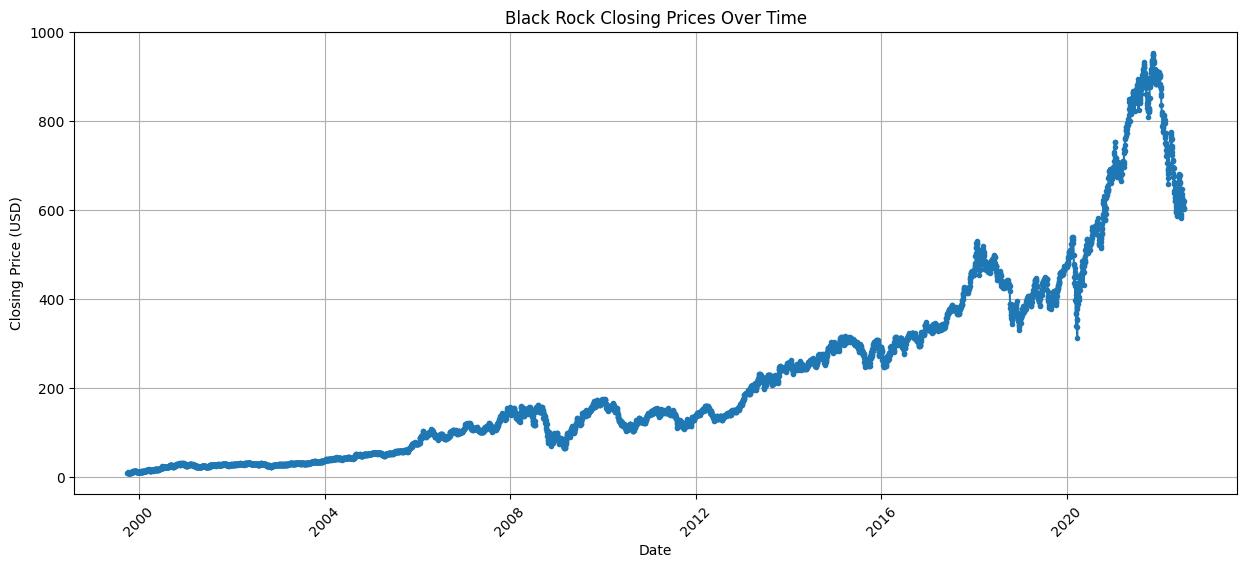

In [ ]:
# Plotting Closing Prices Over Time
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], marker='.')
plt.title('Black Rock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [ ]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [ ]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
# Reshape input data for LSTM ([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Model training
# Initialize a sequential model

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# Defining callbacks
checkpoints = ModelCheckpoint(filepath='my_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[checkpoints, early_stopping])

Epoch 1/100
142/142 [==============================] - 24s 111ms/step - loss: 9.2580e-04 - val_loss: 6.7834e-04
Epoch 2/100
142/142 [==============================] - 15s 104ms/step - loss: 1.8999e-04 - val_loss: 5.6452e-04
Epoch 3/100
142/142 [==============================] - 16s 115ms/step - loss: 1.5220e-04 - val_loss: 8.1194e-04
Epoch 4/100
142/142 [==============================] - 15s 105ms/step - loss: 1.4987e-04 - val_loss: 5.2161e-04
Epoch 5/100
142/142 [==============================] - 15s 104ms/step - loss: 1.4132e-04 - val_loss: 5.6104e-04
Epoch 6/100
142/142 [==============================] - 14s 101ms/step - loss: 1.3464e-04 - val_loss: 6.2220e-04
Epoch 7/100
142/142 [==============================] - 15s 108ms/step - loss: 1.4884e-04 - val_loss: 5.6835e-04
Epoch 8/100
142/142 [==============================] - 16s 111ms/step - loss: 1.2713e-04 - val_loss: 4.9007e-04
Epoch 9/100
142/142 [==============================] - 16s 110ms/step - loss: 1.1915e-04 - val_loss: 5.4

In [13]:
# Prediction and performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

34/34 [==============================] - 1s 31ms/step


In [14]:
# Calculate RMSE
import math
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train Data RMSE: {train_rmse}")
print(f"Test Data RMSE: {test_rmse}")

Train Data RMSE: 174.02647358170006
Test Data RMSE: 602.2388948208699


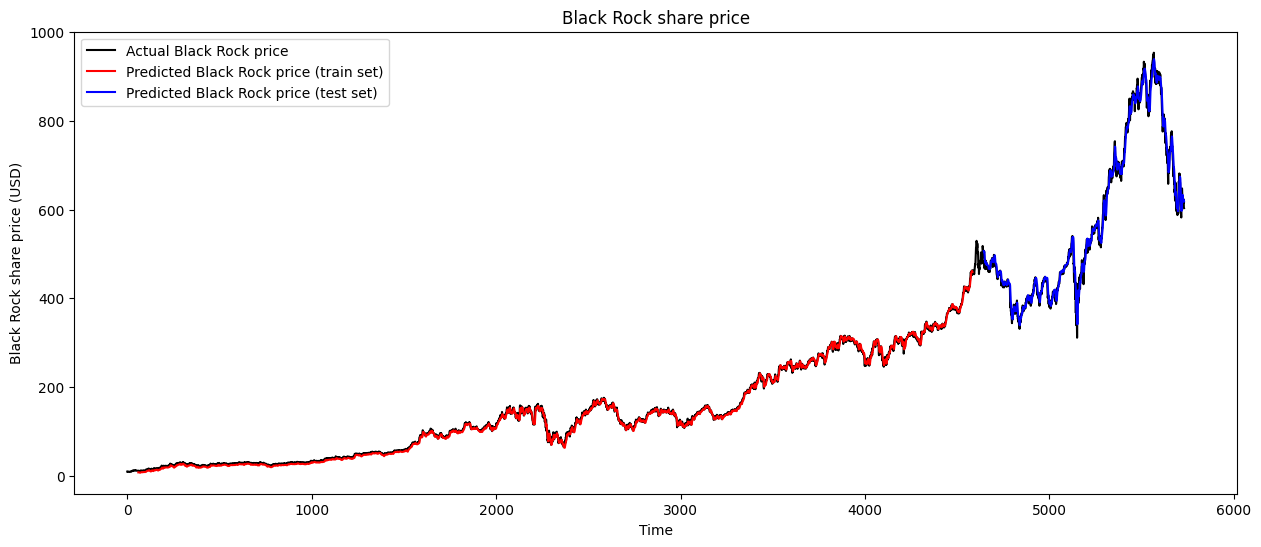

In [15]:
# Initialize an array for plotting the train predictions

look_back = 60

trainPredictPlot = np.empty_like(df['Close'])
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(df['Close'])
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(df['Close']) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual Black Rock price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted Black Rock price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted Black Rock price (test set)")

plt.title(f"Black Rock share price")
plt.xlabel("Time")
plt.ylabel(f"Black Rock share price (USD)")
plt.legend()
plt.show()


In [16]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 40ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 618.5934448242188
Day 2: Predicted Price = 617.9163208007812
Day 3: Predicted Price = 618.2908325195312
Day 4: Predicted Price = 619.0637817382812
Day 5: Predicted Price = 619.9262084960938
Day 6: Predicted Price = 620.7650146484375
Day 7: Predicted Price = 621.558349609375
Day 8: Predicted Price = 622.3170166015625
Day 9: Predicted Price = 623.0580444335938
Day 10: Predicted Price = 623.7946166992188


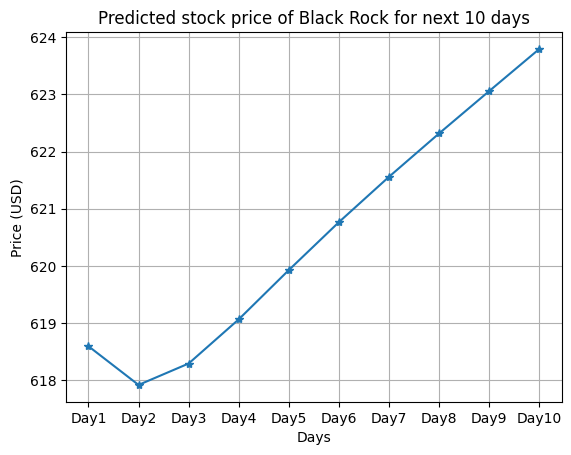

In [17]:
company_name = "Black Rock"

# Plotting the predictions for the next 10 days
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()


In [18]:
pip install pandas numpy scikit-learn matplotlib tslearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

In [20]:
# Load dataset
df = pd.read_csv('/content/BLK.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use only the 'Close' column
data = df['Close'].values

In [21]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [22]:
# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

In [23]:
n_steps = 5
X, y = create_sequences(data_scaled, n_steps)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# KNN Regressor for forecasting
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.reshape(X_train.shape[0], n_steps), y_train)
y_pred = knn.predict(X_test.reshape(X_test.shape[0], n_steps))

# Inverse transform to get actual values
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

In [25]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 205.020


In [26]:
# Time Series Clustering
n_clusters = 3
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10)
clusters = model.fit_predict(data_scaled.reshape(data_scaled.shape[0], 1, 1))

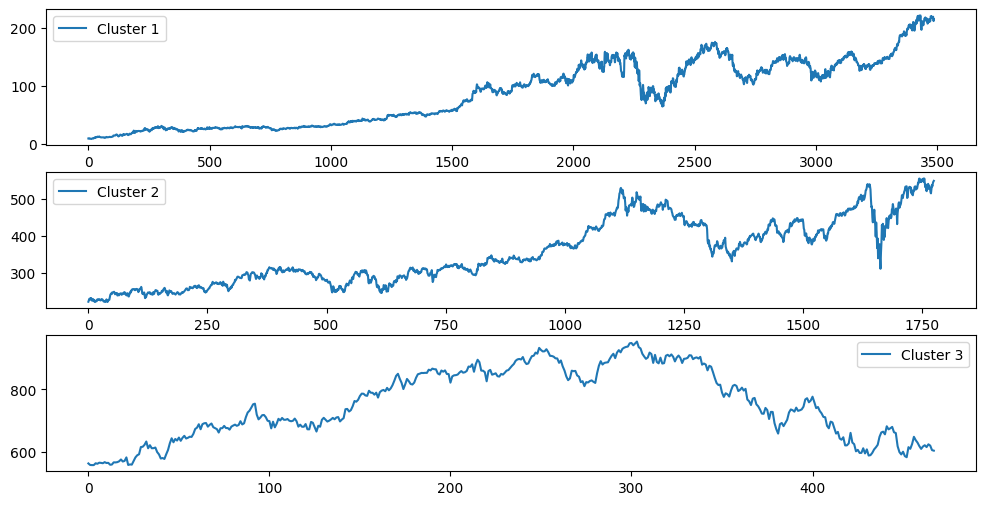

In [27]:
# Plot clustering results
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    plt.subplot(n_clusters, 1, i + 1)
    plt.plot(data[clusters == i], label='Cluster ' + str(i+1))
    plt.legend()
plt.show()

In [32]:
# Ensure X_test is the test dataset and scaler is the MinMaxScaler instance used before
# Use the last sequence from the test set as the starting point
last_sequence = X_test[-1].reshape(1, -1)

# Generate predictions for the next 10 days
predictions_next_10_days = []

for _ in range(10):
    # Predict the next day
    next_day_prediction = knn.predict(last_sequence)

    # Append the prediction (rescaled to original)
    predictions_next_10_days.append(scaler.inverse_transform(next_day_prediction)[0, 0])

    # Update the last sequence for the next prediction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1] = next_day_prediction

# Print the predictions for the next 10 days
print("Predictions for the next 10 days using KNN:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction}")


Predictions for the next 10 days using KNN:
Day 1: Predicted Price = 456.916162109375
Day 2: Predicted Price = 457.25718383789064
Day 3: Predicted Price = 457.4589538574219
Day 4: Predicted Price = 458.04278564453125
Day 5: Predicted Price = 457.84101562499995
Day 6: Predicted Price = 458.5052307128906
Day 7: Predicted Price = 458.5052307128906
Day 8: Predicted Price = 458.5052307128906
Day 9: Predicted Price = 457.2571838378906
Day 10: Predicted Price = 457.2571838378906


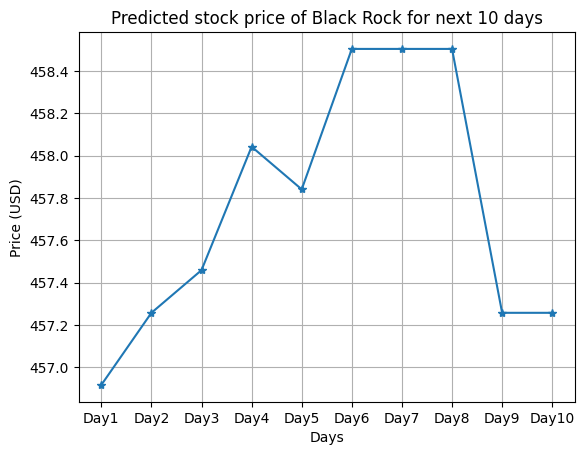

In [33]:
company_name = "Black Rock"

# Plotting the predictions for the next 10 days
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error


In [34]:
# Load the dataset
df = pd.read_csv('/content/BLK.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Use only the 'Close' column
data = df.filter(['Close'])


In [35]:
# Convert the dataframe to a numpy array and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

In [36]:
# Define training data size
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Create a training data set
train_data = scaled_data[0:training_data_len]

# Create the training data set
n_past = 60
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i-n_past:i, 0])
    y_train.append(train_data[i, 0])

# Convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for CNN (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [37]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [38]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=100)

# Create the testing data set
test_data = scaled_data[training_data_len - n_past:, :]

Epoch 1/100
4525/4525 [==============================] - 14s 3ms/step - loss: 2.3090e-04
Epoch 2/100
4525/4525 [==============================] - 13s 3ms/step - loss: 1.2121e-04
Epoch 3/100
4525/4525 [==============================] - 15s 3ms/step - loss: 8.7427e-05
Epoch 4/100
4525/4525 [==============================] - 14s 3ms/step - loss: 7.9818e-05
Epoch 5/100
4525/4525 [==============================] - 14s 3ms/step - loss: 6.8533e-05
Epoch 6/100
4525/4525 [==============================] - 15s 3ms/step - loss: 6.4202e-05
Epoch 7/100
4525/4525 [==============================] - 13s 3ms/step - loss: 6.0761e-05
Epoch 8/100
4525/4525 [==============================] - 14s 3ms/step - loss: 5.6808e-05
Epoch 9/100
4525/4525 [==============================] - 13s 3ms/step - loss: 5.5236e-05
Epoch 10/100
4525/4525 [==============================] - 13s 3ms/step - loss: 5.3658e-05
Epoch 11/100
4525/4525 [==============================] - 13s 3ms/step - loss: 5.0394e-05
Epoch 12/100
4525/4

In [39]:
# Create the data sets X_test and y_test
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i-n_past:i, 0])
    y_test.append(test_data[i, 0])

# Convert the data to a numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [40]:
# Get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

36/36 [==============================] - 0s 2ms/step


In [41]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, scaler.inverse_transform(test_data[n_past:])))
print(f"RMSE: {rmse}")


RMSE: 596.7722508707205


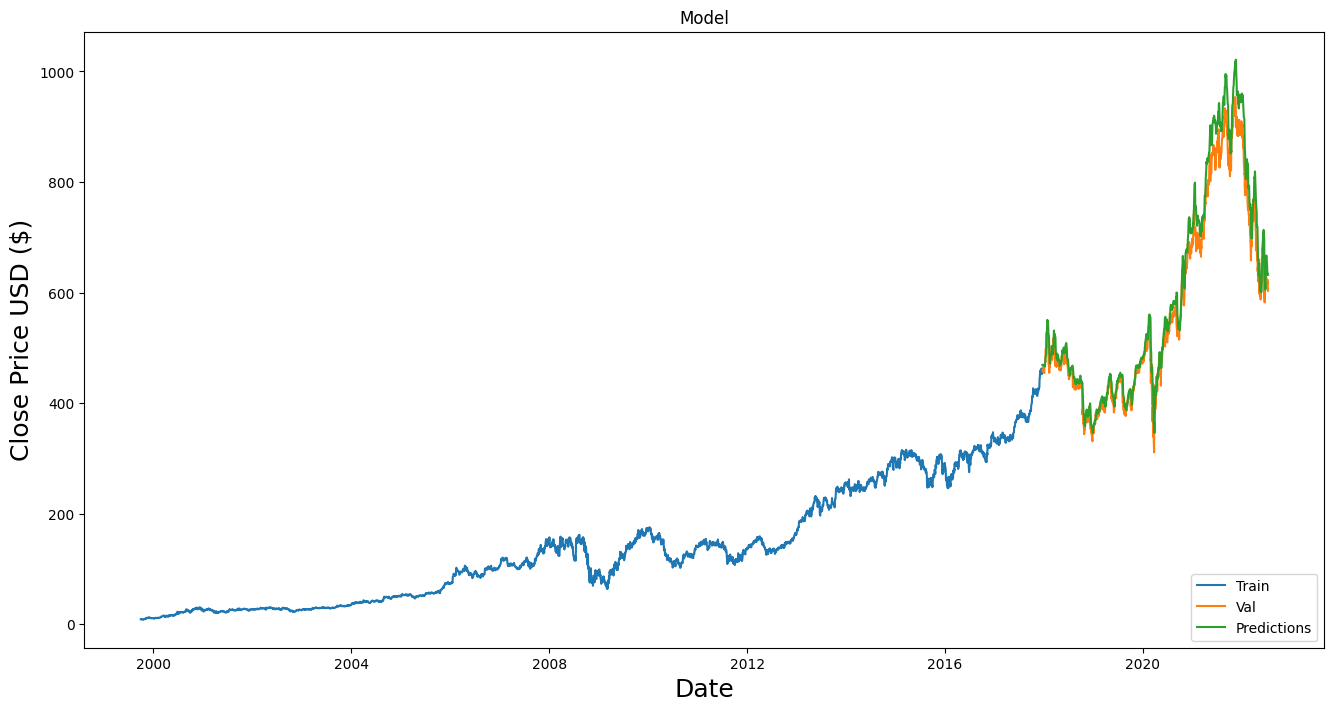

In [42]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [43]:
# Ensure X_test is the test dataset, model is your trained CNN model, and scaler is the MinMaxScaler instance used before
# Use the last sequence from the test set as the starting point
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the CNN model
last_sequence = last_sequence.reshape(1, last_sequence.shape[0], 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []

for _ in range(10):
    # Predict the next day using the CNN model
    next_day_prediction = model.predict(last_sequence)

    # Append the prediction (rescaled to original scale)
    next_day_prediction_rescaled = scaler.inverse_transform(next_day_prediction)[0, 0]
    predictions_next_10_days.append(next_day_prediction_rescaled)

    # Update the last sequence with the predicted value for the next prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

# Print the predictions for the next 10 days
print("Predictions for the next 10 days using CNN:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction}")


1/1 [==============================] - 0s 22ms/step
Predictions for the next 10 days using CNN:
Day 1: Predicted Price = 632.6055297851562
Day 2: Predicted Price = 632.7720336914062
Day 3: Predicted Price = 639.3203735351562
Day 4: Predicted Price = 645.29541015625
Day 5: Predicted Price = 652.934814453125
Day 6: Predicted Price = 663.3648681640625
Day 7: Predicted Price = 673.719970703125
Day 8: Predicted Price = 688.2408447265625
Day 9: Predicted Price = 701.251953125
Day 10: Predicted Price = 717.1882934570312


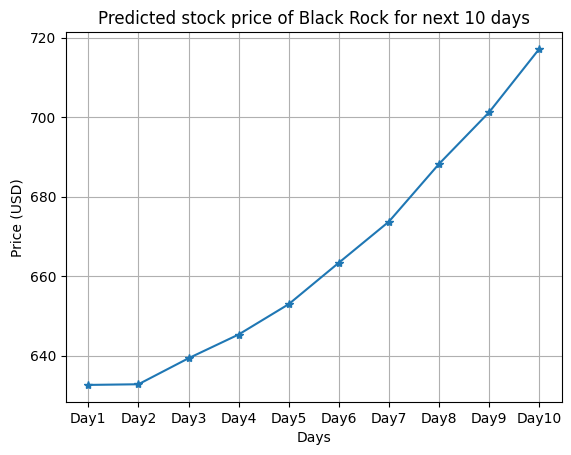

In [44]:
company_name = "Black Rock"

# Plotting the predictions for the next 10 days
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()